In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import refer

ds = refer.REFER(
    data_root='/scratch/gsk6me/WORLDMODELS/refcoco',
    image_root='/scratch/gsk6me/WORLDMODELS',
    dataset='refcocog',
    splitBy='umd'
)


loading dataset refcocog into memory...
creating index...
index created.
DONE (t=6.21s)


## Generate captions with Phi-3 vision

In [45]:
from multimodal_phi_model import vlm, processor

/sfs/weka/scratch/gsk6me/WORLDMODELS/crl-online-policies/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.02s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Bounding box (XYWH): [161.75, 167.8, 235.35, 140.44]


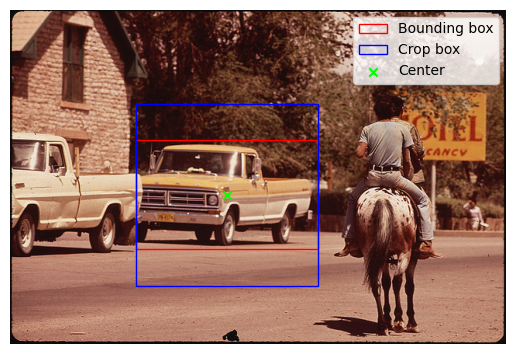

In [46]:
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ref_ids = ds.getRefIds()
ref = ds.loadRefs(ref_ids[136])[0]
image = PIL.Image.open(f"/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_{ref['image_id']:012d}.jpg")
annot = ds.Anns[ref['ann_id']]
bbox = annot['bbox']

print("Bounding box (XYWH):", bbox)

center_x = bbox[0] + bbox[2] / 2
center_y = bbox[1] + bbox[3] / 2

# make square box crop
size = max(bbox[2], bbox[3])
crop_x = center_x - size / 2
crop_y = center_y - size / 2

plt.imshow(image)
plt.gca().add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color='r', label='Bounding box'))
plt.gca().add_patch(patches.Rectangle((crop_x, crop_y), size, size, fill=False, color='b', label='Crop box'))
plt.scatter(center_x, center_y, marker='x', label='Center', color=(0, 1, 0, 1))
plt.legend()
plt.axis('off')

plt.show()

In [64]:
import torch
import time

crop = image.crop((crop_x, crop_y, crop_x + size, crop_y + size))

prompt = f"<|user|>\n<|image_1|>Please describe the central subject of this image ({ds.Cats[ref['category_id']]}). Write your response as a noun phrase, and if possible, include information about directly visible attributes, such as shape, texture, and/or material. Do not include information about the surrounding environment; only describe the intrinsic physical attributes of the subject.<|end|>\n<|assistant|>\n"

inputs = processor(prompt, [crop], return_tensors="pt").to("cuda:0")

generation_args = {
    "temperature": 0.0,
    "do_sample": False,
    "max_new_tokens": 500,
}

start = time.time()

with torch.no_grad():
    generate_ids = vlm.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

end = time.time()

# remove input tokens 
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

print(response)
print(end - start, 'seconds')


A yellow and white vintage pickup truck.
0.7412025928497314 seconds


In [24]:
from pycocotools.coco import COCO

pycocotools.coco.COCO

In [26]:
coco_train2014 = COCO('/scratch/gsk6me/WORLDMODELS/coco_annotations/instances_train2014.json')

loading annotations into memory...
Done (t=10.49s)
creating index...
index created!


For now, because there are so many possible annotations, we will only select a subset of 100 images (~1000 annotations) for initial finetuning.

In [67]:
images_to_use = []

for image_id, anns in coco_train2014.imgToAnns.items():
    if len(anns) > 4 and image_id not in images_to_use_old:
        images_to_use.append(image_id)
        
        if len(images_to_use) == 400:
            break

In [62]:
images_to_use_old = images_to_use

In [69]:
import torch
vlm = torch.compile(vlm)

In [ ]:
import tqdm
import time
import torch
import PIL.Image

# Extract training sentences.
visualize_images = False

captions = {}
coco_image_root = "/scratch/gsk6me/WORLDMODELS"

for image_id in tqdm.tqdm(images_to_use):
    image_path = f"train2014/COCO_train2014_{image_id:012d}.jpg"
    image = PIL.Image.open(f"{coco_image_root}/{image_path}")
    image_width = image.width
    image_height = image.height
    annots = coco_train2014.imgToAnns[image_id]
    for annot in annots:
        ann_id = annot['id']
        category_id = annot['category_id']
        category_name = coco_train2014.cats[category_id]['name']
        bbox = annot['bbox']
        
        center_x = bbox[0] + bbox[2] / 2
        center_y = bbox[1] + bbox[3] / 2

        # make square box crop
        size = max(bbox[2], bbox[3])
        crop_x = center_x - size / 2
        crop_y = center_y - size / 2

        if visualize_images:
            print("Bounding box (XYWH):", bbox)

            plt.title("Category: " + category_name)
            plt.imshow(image)
            plt.gca().add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color='r', label='Bounding box'))
            plt.gca().add_patch(patches.Rectangle((crop_x, crop_y), size, size, fill=False, color='b', label='Crop box'))
            plt.scatter(center_x, center_y, marker='x', label='Center', color=(0, 1, 0, 1))
            plt.legend()
            plt.axis('off')

            plt.show()

        ### Generate object caption.
        crop = image.crop((crop_x, crop_y, crop_x + size, crop_y + size))

        prompt = f"<|user|>\n<|image_1|>Please describe the central subject of this image ({category_name}). Write your response as a noun phrase, and if possible, include information about directly visible attributes, such as shape, texture, and/or material. Do not include information about the surrounding environment; only describe the intrinsic physical attributes of the subject. Do not use the word 'image'.<|end|>\n<|assistant|>\n"

        inputs = processor(prompt, [crop], return_tensors="pt").to("cuda:0")

        generation_args = {
            "do_sample": False,
            "max_new_tokens": 500,
        }

        start = time.time()

        with torch.no_grad():
            generate_ids = vlm.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

        end = time.time()

        # remove input tokens 
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        caption = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

        captions[ann_id] = {
            "ann_id": ann_id,
            "image_url": image_path,
            "image_id": image_id,
            "caption": caption,
            "bbox_xywh": bbox,
        }


 85%|████████▌ | 341/400 [58:56<12:45, 12.97s/it]  

In [71]:
# Save the captions.

nfiltered = 0

with open("train_object_captions_4k.jsonl", "w") as f:
    for ann_id, caption in captions.items():
        image = PIL.Image.open('/scratch/gsk6me/WORLDMODELS/' + caption['image_url'])
        width = image.width
        height = image.height
        bbox = caption['bbox_xywh']
        
        if 'does not' in caption['caption'].lower():
            nfiltered += 1
            continue
            
        if 'the image' in caption['caption'].lower():
            nfiltered += 1
            continue
            
        if 'blurry' in caption['caption'].lower():
            nfiltered += 1
            continue
        
        x0_quant = int((bbox[0] / width) * 1024)
        y0_quant = int((bbox[1] / height) * 1024)
        x1_quant = int(((bbox[0] + bbox[2]) / width) * 1024)
        y1_quant = int(((bbox[1] + bbox[3]) / height) * 1024)
        
        row = {
            'image': caption['image_url'],
            'prefix': f'Describe <loc{x0_quant:04d}><loc{y0_quant:04d}><loc{x1_quant:04d}><loc{y1_quant:04d}>',
            'suffix': caption['caption'],
            'bbox_x': bbox[0],
            'bbox_y': bbox[1],
            'bbox_w': bbox[2],
            'bbox_h': bbox[3],
            'image_width': width,
            'image_height': height,
        }
        
        json.dump(row, f)
        f.write("\n")
        
print("Filtered", nfiltered, "captions for lack of detection")

Filtered 196 captions for lack of detection


### Visualizing Data Quality

In [5]:
import json
import PIL.Image
with open("train_object_captions_4k.jsonl") as f:
    captions = [json.loads(line) for line in f.read().split("\n") if line]

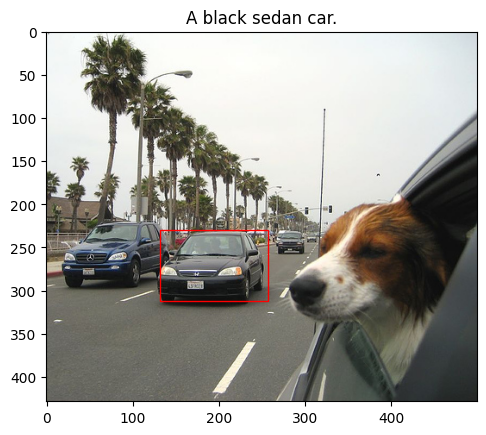

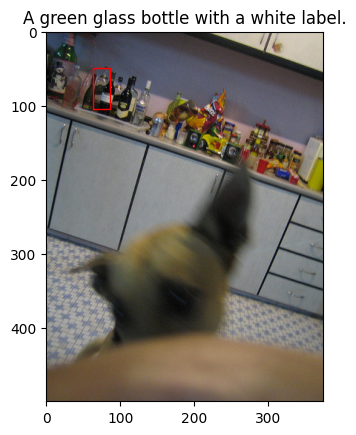

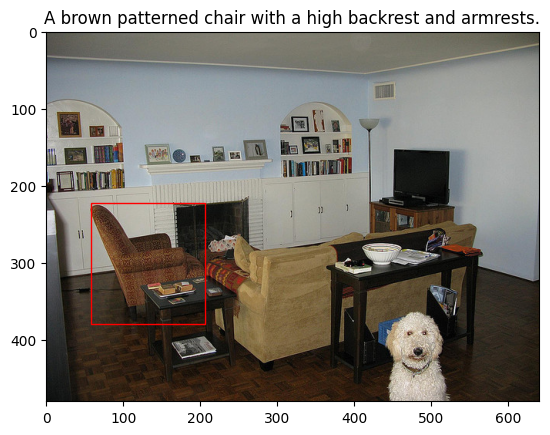

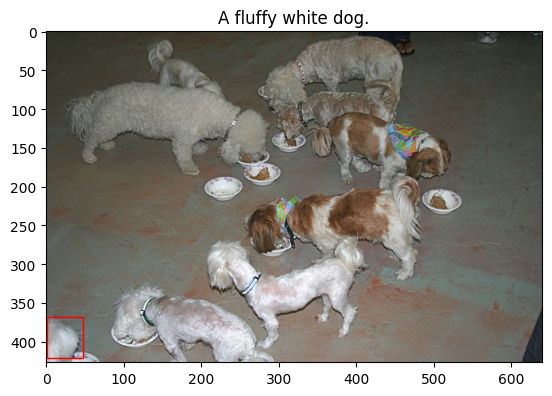

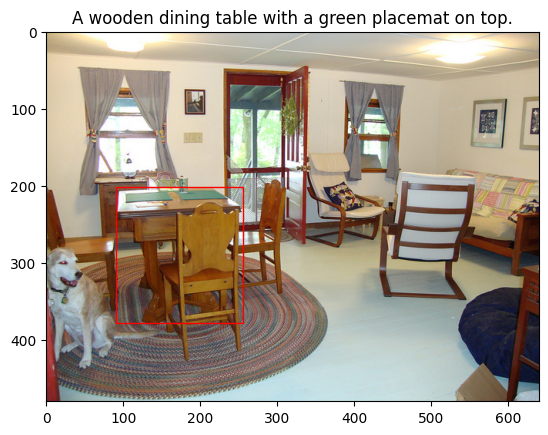

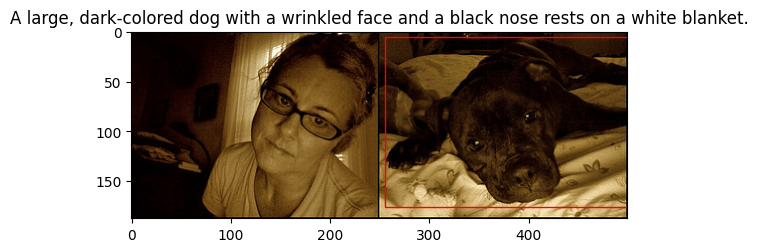

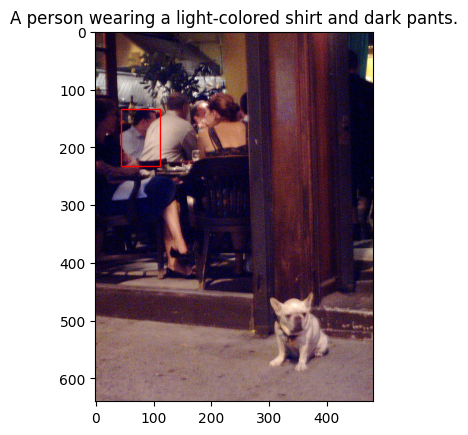

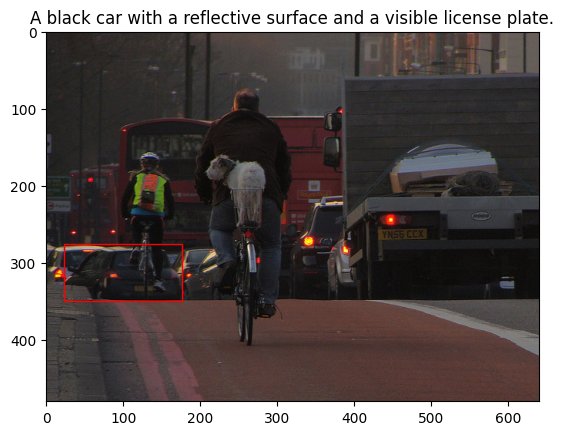

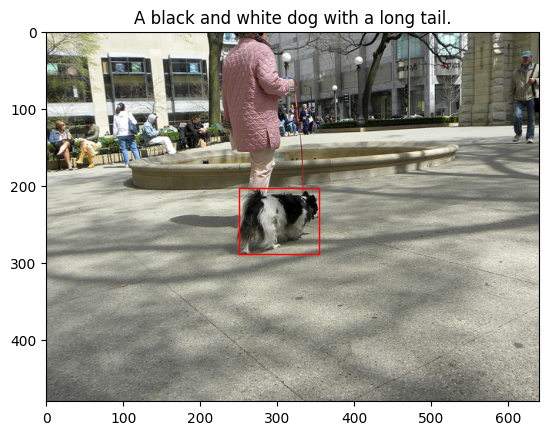

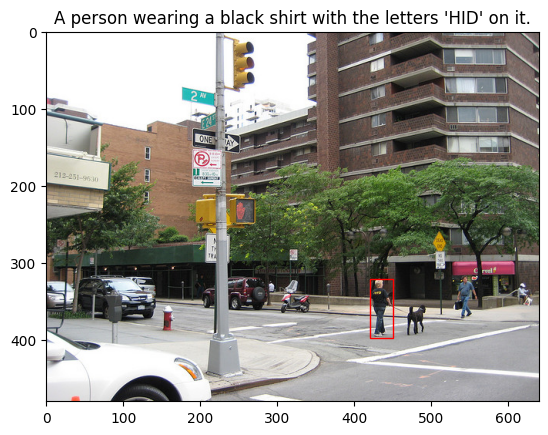

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

coco_image_root = '/scratch/gsk6me/WORLDMODELS'

np.random.seed(0)
for index in np.random.permutation(len(captions))[:10]:
    caption = captions[index]
    image = PIL.Image.open(os.path.join(coco_image_root, caption['image']))
    plt.title(caption['suffix'])
    plt.imshow(image)
    plt.gca().add_patch(patches.Rectangle((caption['bbox_x'], caption['bbox_y']), caption['bbox_w'], caption['bbox_h'], fill=False, color='red'))
    plt.show()


### Old code for interacting with RefCOCO dataset

In [90]:
import tqdm

# Doing this in larger batches.
# Extract training sentences.
visualize_images = False

captions = {}

with open("synthetic_captions.json") as f:
    captions_list = json.load(f)
    
seen_ann_ids = {c['ann_id'] for c in captions_list}

with tqdm.tqdm(total=5000 - len(seen_ann_ids)) as pbar:
    for ref_id, ref in ds.Refs.items():
        if ref['split'] != 'train':
            continue

        image_path = f"/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_{ref['image_id']:012d}.jpg"
        image = PIL.Image.open(image_path)
        image_width = image.width
        image_height = image.height

        if ref['ann_id'] in seen_ann_ids:
            # We only want to iterate through annotations that were in the training split of RefCOCOg.
            continue
            
        annot = ds.Anns[ref['ann_id']]
        bbox = annot['bbox']

        if visualize_images:
            print("Bounding box (XYWH):", bbox)

            center_x = bbox[0] + bbox[2] / 2
            center_y = bbox[1] + bbox[3] / 2

            # make square box crop
            size = max(bbox[2], bbox[3])
            crop_x = center_x - size / 2
            crop_y = center_y - size / 2

            plt.imshow(image)
            plt.gca().add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, color='r', label='Bounding box'))
            plt.gca().add_patch(patches.Rectangle((crop_x, crop_y), size, size, fill=False, color='b', label='Crop box'))
            plt.scatter(center_x, center_y, marker='x', label='Center', color=(0, 1, 0, 1))
            plt.legend()
            plt.axis('off')

            plt.show()

        seen_ann_ids.add(ref['ann_id'])

        ### Generate object caption.
        crop = image.crop((crop_x, crop_y, crop_x + size, crop_y + size))

        prompt = f"<|user|>\n<|image_1|>Please describe the central subject of this image ({ds.Cats[ref['category_id']]}). Write your response as a noun phrase, and if possible, include information about directly visible attributes, such as shape, texture, and/or material. Do not include information about the surrounding environment; only describe the intrinsic physical attributes of the subject. Do not use the word 'image'.<|end|>\n<|assistant|>\n"

        inputs = processor(prompt, [crop], return_tensors="pt").to("cuda:0")

        generation_args = {
            "temperature": 0.0,
            "do_sample": False,
            "max_new_tokens": 500,
        }

        start = time.time()

        with torch.no_grad():
            generate_ids = vlm.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

        end = time.time()

        # remove input tokens 
        generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
        caption = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        
        captions[ref['ann_id']] = {
            "ann_id": ref["ann_id"],
            "image_url": image_path,
            "image_id": ref["image_id"],
            "caption": caption,
            "bbox_xywh": bbox,
        }
        
        pbar.update()

        if len(captions) + len(seen_ann_ids) == 5000:
            break


 50%|█████     | 2000/4000 [40:04<40:04,  1.20s/it]  


In [2]:
import json
with open("synthetic_captions.json") as f:
    captions = json.load(f)
distinct_anns = len({cap['ann_id'] for cap in captions})
distinct_imgs = len({cap['image_id'] for cap in captions})
print(distinct_anns, distinct_imgs)
# Ahh. so there are not a lot of annotations per image. Let's fix that by using the COCO dataset.
# This should improve object localization. I'll aim for ~5 objects per image.

2000 1866


In [99]:
combined_captions = list(captions.values())

with open("synthetic_captions.json") as f:
    combined_captions.extend(json.load(f))


In [102]:
combined_captions[0]

{'ann_id': 465976,
 'image_url': '/scratch/gsk6me/WORLDMODELS/train2014/COCO_train2014_000000402726.jpg',
 'image_id': 402726,
 'caption': 'A person wearing a camouflage jacket and cargo pants.',
 'bbox_xywh': [161.75, 167.8, 235.35, 140.44]}

In [104]:
seen_ann_ids = set()

assert len(combined_captions) == len({cap['ann_id'] for cap in combined_captions})

fixed_combined_captions = []

for i in range(len(combined_captions)):
    combined_captions[i]['bbox_xywh'] = ds.Anns[combined_captions[i]['ann_id']]['bbox']


In [105]:
import json

with open("synthetic_captions.json", "w") as f:
    json.dump(list(captions.values()), f)

## Generating `.jsonl` dataset from this

In [80]:
import json

with open("synthetic_captions.json", "w") as f:
    json.dump(list(captions.values()), f)

In [106]:
nfiltered = 0

with open("train_object_captions.jsonl", "w") as f:
    for ann_id, caption in captions.items():
        image = PIL.Image.open(caption['image_url'])
        width = image.width
        height = image.height
        bbox = caption['bbox_xywh']
        
        if 'does not' in caption['caption'].lower():
            nfiltered += 1
            continue
            
        if 'the image' in caption['caption'].lower():
            nfiltered += 1
            continue
        
        x0_quant = int((bbox[0] / width) * 1024)
        y0_quant = int((bbox[1] / height) * 1024)
        x1_quant = int(((bbox[0] + bbox[2]) / width) * 1024)
        y1_quant = int(((bbox[1] + bbox[3]) / height) * 1024)
        
        row = {
            'image': caption['image_url'],
            'prefix': f'Describe <loc{x0_quant:04d}><loc{y0_quant:04d}><loc{x1_quant:04d}><loc{y1_quant:04d}>',
            'suffix': caption['caption'],
            'bbox_x': bbox[0],
            'bbox_y': bbox[1],
            'bbox_w': bbox[2],
            'bbox_h': bbox[3],
        }
        
        json.dump(row, f)
        f.write("\n")
        
print("Filtered", nfiltered, "captions for lack of detection")


Filtered 60 captions for lack of detection
